In [1]:
import os
import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.model import unet_model
from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from src.data_utils import plot_sample_batch, create_mask
from src.model_utils import (
    dice_coeff,
    dice_loss,
    bce_dice_loss,
    tversky,
    tversky_loss,
    focal_tversky_loss,
    dice_coeff_per_class,
    evaluate_per_class_dice,
)


%load_ext lab_black
%load_ext autoreload
%autoreload 2

2022-10-17 16:18:37.114499: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 16:18:43.597003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-10-17 16:18:43.599083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-10-17 1

## Load Test Set

In [7]:
IMG_SHAPE = (256, 1600)
BATCH_SIZE = 8
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"
LOSSES = {
    "dice_loss": dice_loss,
    "bce_dice_loss": bce_dice_loss,
    "tversky_loss": tversky_loss,
    "focal_tversky_loss": focal_tversky_loss,
}
METRICS = {
    "dice_coeff": dice_coeff,
    "tversky": tversky,
}

# instantiate dataset and pipelne
# sd = SegmentationDataset(
#     label_file=ANNOTATIONS_PATH,
#     img_dir_path=TRAIN_IMG_PATH,
#     img_shape=IMG_SHAPE,
# )

# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.1)

# small sample
train_imgs = train_imgs[:200]
test_imgs = test_imgs[:200]

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

# create dataset pipelines
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,
        "cache": False,
        "shuffle_buffer_size": False,
        "batch_size": BATCH_SIZE,
        "prefetch": False,
    },
)
train_dataset = sdp(X_train, y_train, is_train=True)
test_dataset = sdp(X_test, y_test, is_train=True)

AUGMENTING!!
Batching
AUGMENTING!!
Batching


## Inference

In [3]:
# MODEL_PATH = "../logs/unet-epochs_15-lr_0.005-channels_512-loss_dice_loss-20221012-175613/best_model.h5"
MODEL_PATH = "../logs/unet-epochs_100-lr_0.01-channels_512-loss_tversky_loss-20221014-135310/best_model.h5"


# unet_model = tf.keras.models.load_model(
#     MODEL_PATH,
# )

unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

In [8]:
sample = list(test_dataset.take(1).as_numpy_iterator())

x = sample[0][0]
y_true = sample[0][1]
y_pred = unet_model.predict(x)

x.shape, y_true.shape, y_pred.shape

1/1 [==============================] - 0s 104ms/step


((8, 256, 1600, 3), (8, 256, 1600, 5), (8, 256, 1600, 5))

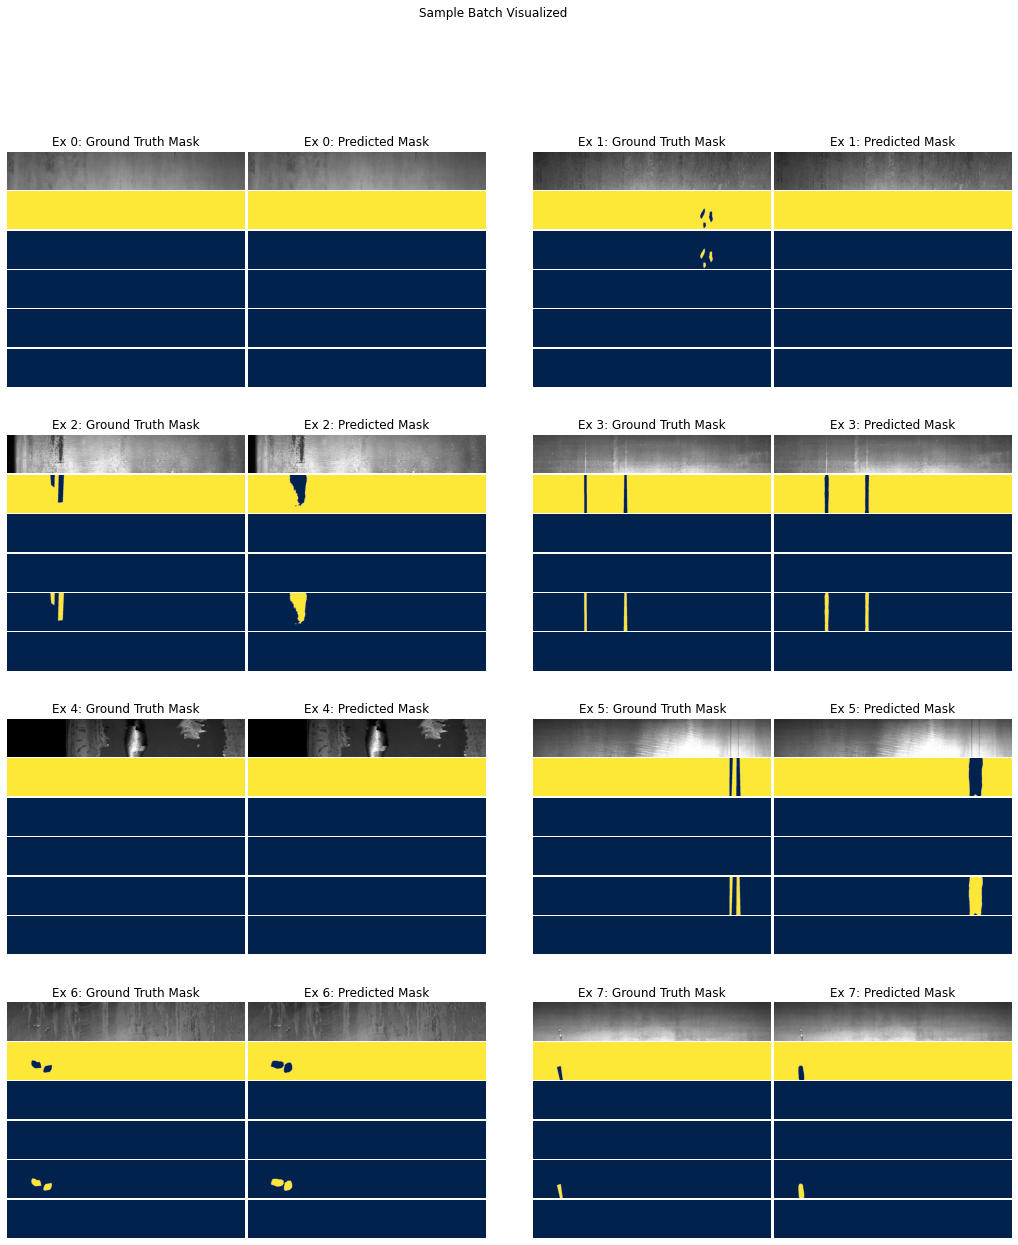

In [9]:
plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

### Plot predictions from multiple batches

1/1 [==============================] - 0s 88ms/step


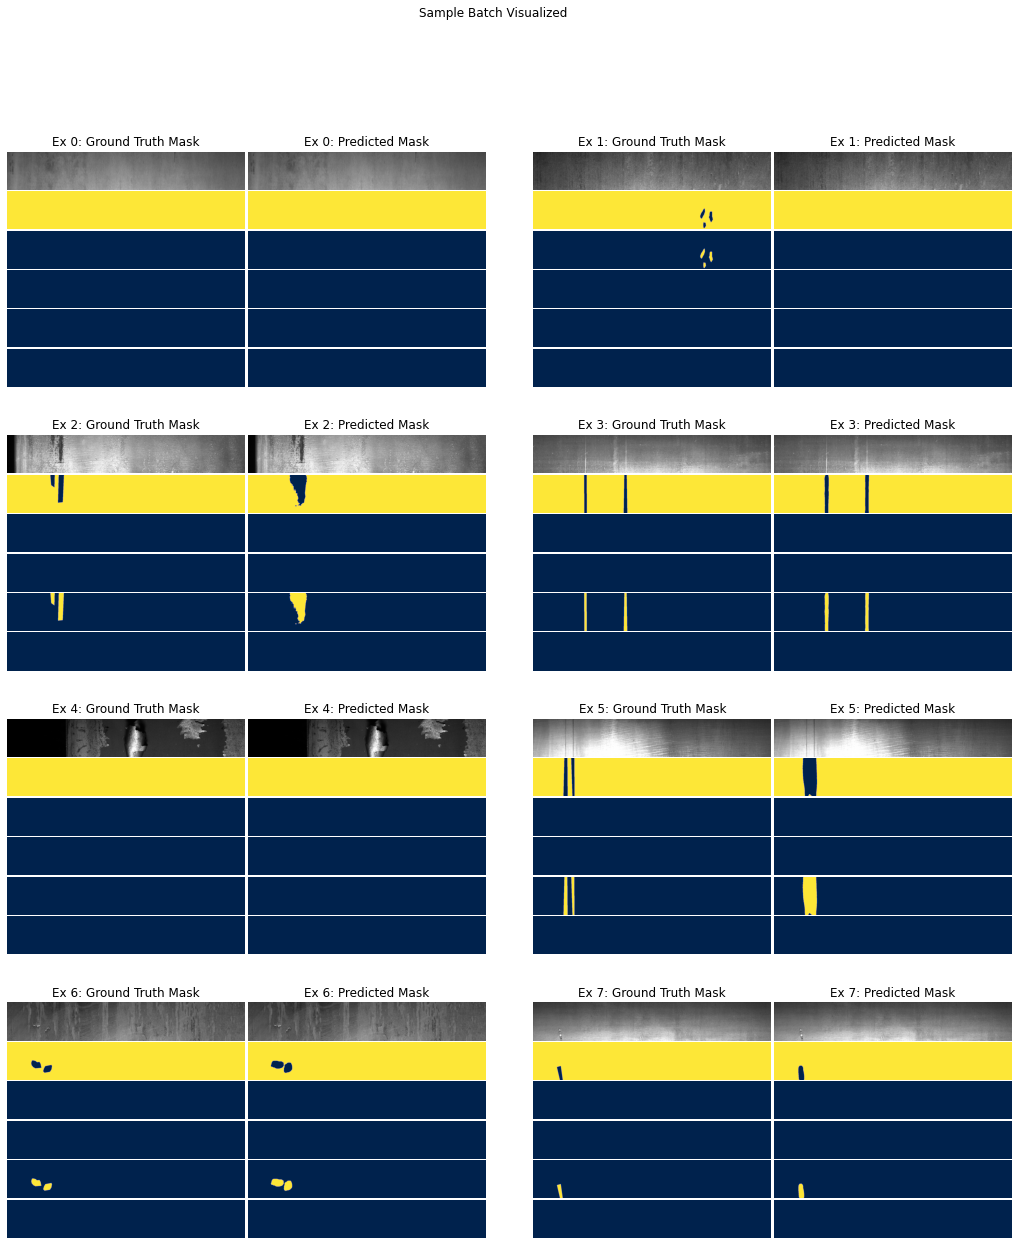

1/1 [==============================] - 0s 86ms/step


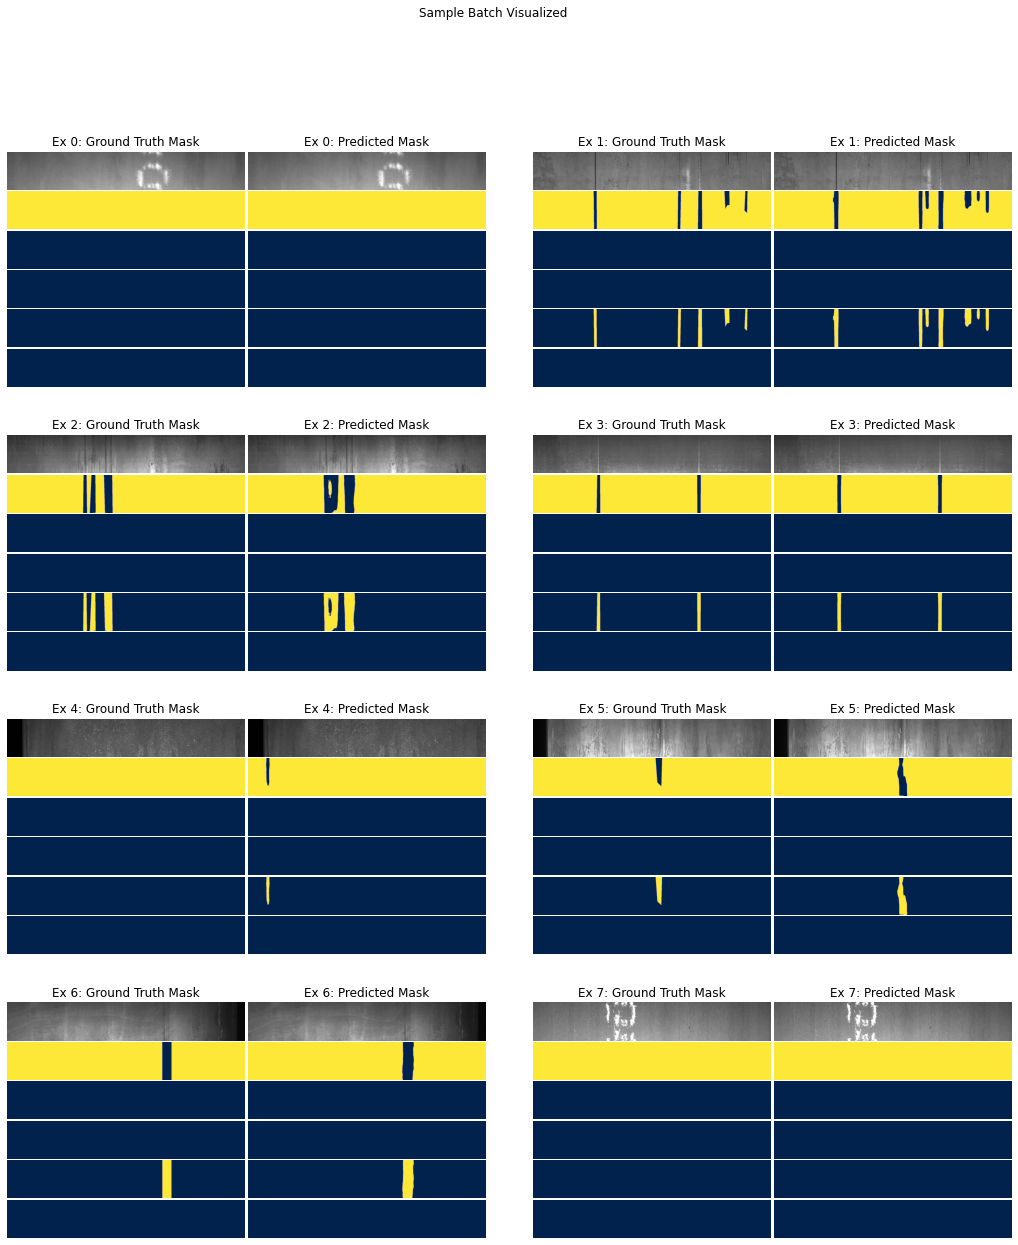

1/1 [==============================] - 0s 84ms/step


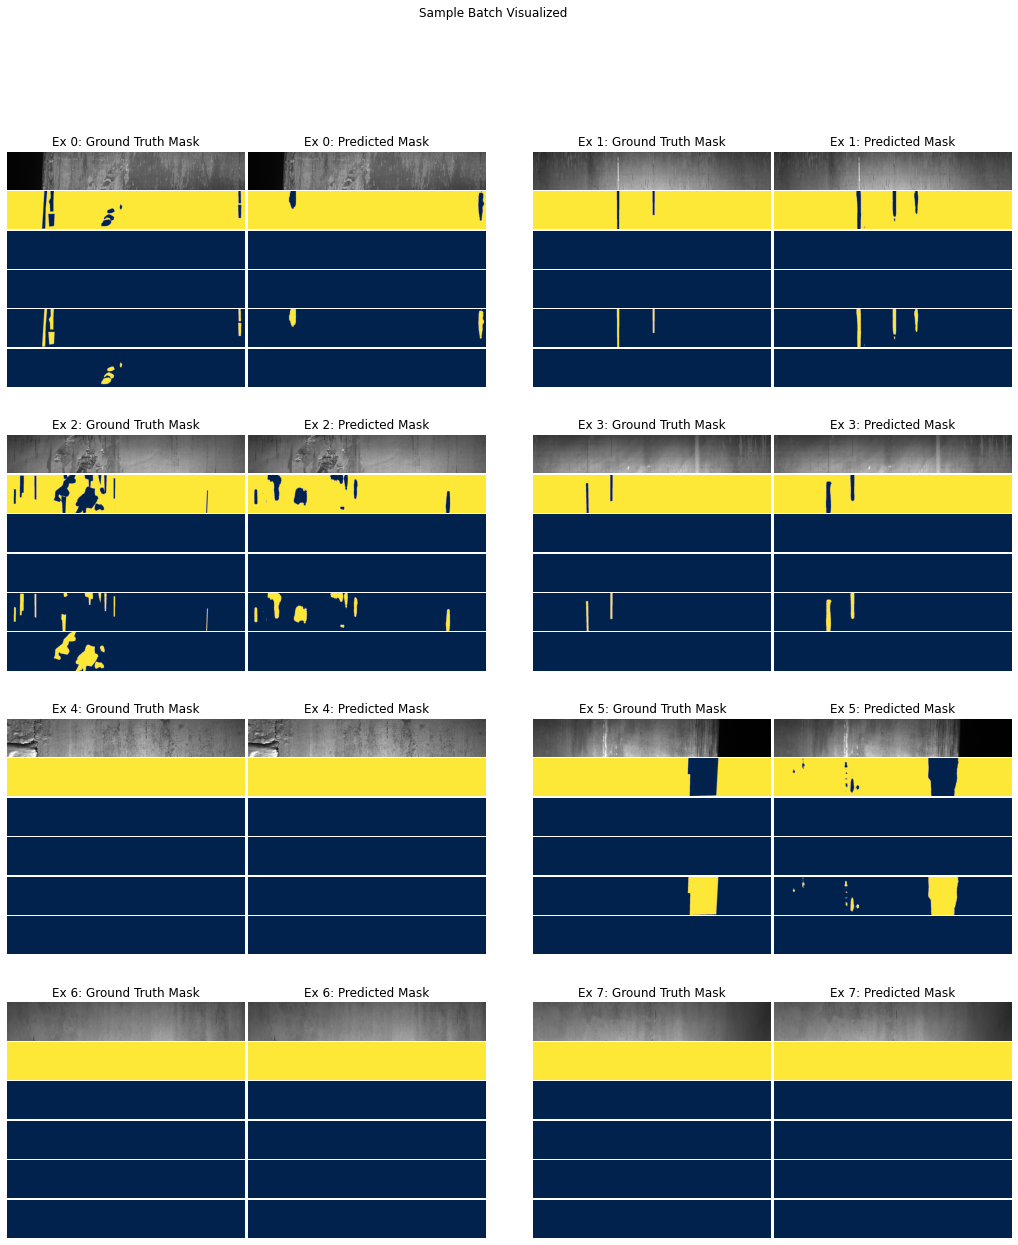

1/1 [==============================] - 0s 56ms/step


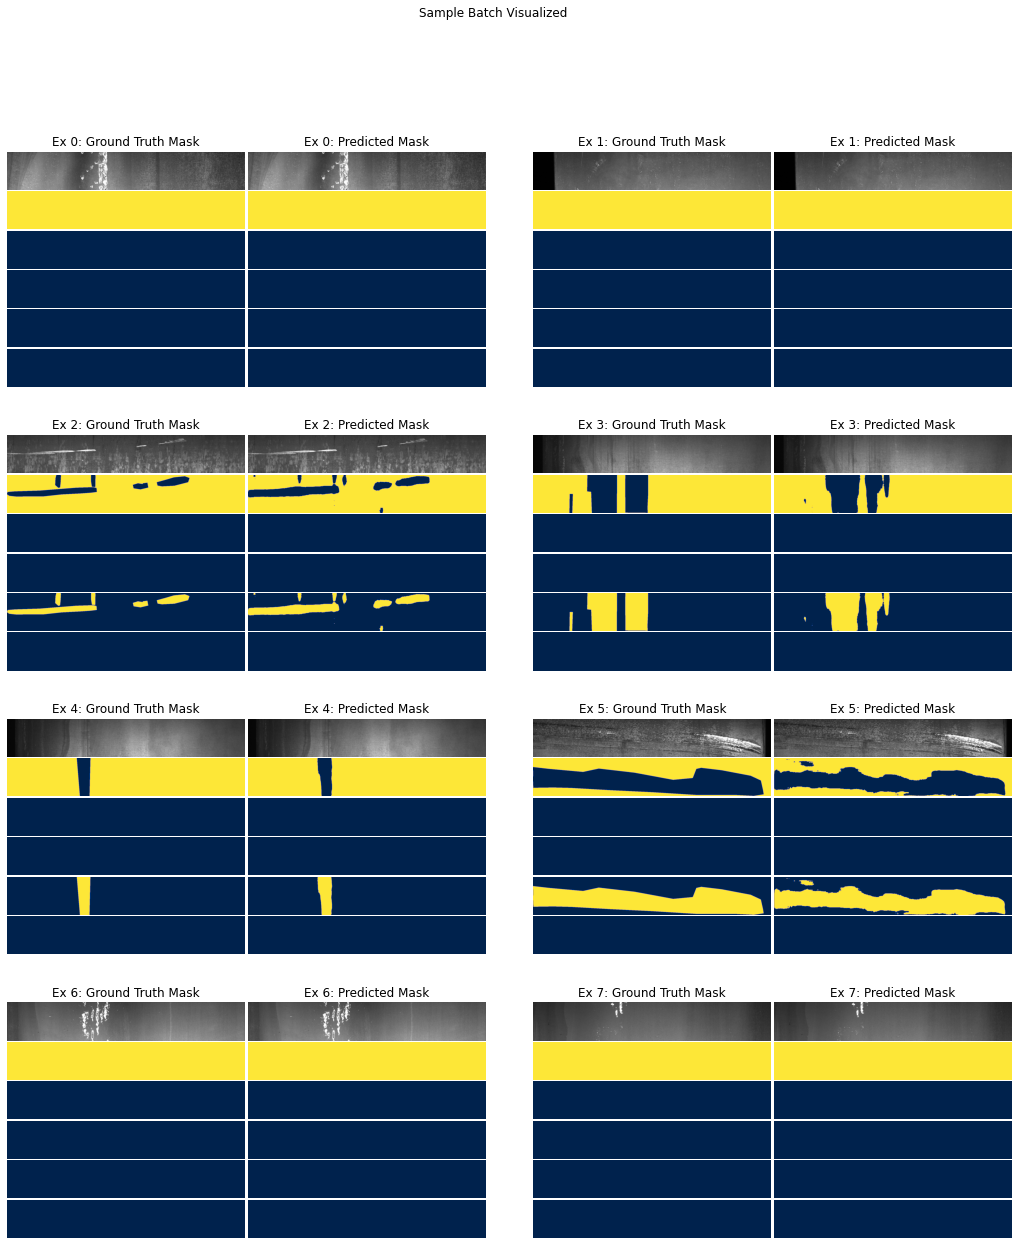

In [10]:
sample = list(test_dataset.take(4).as_numpy_iterator())

for batch in sample:
    x = batch[0]
    y_true = batch[1]
    y_pred = unet_model.predict(x)

    plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred)

## Per Class Evaluation

In [11]:
class_scores = evaluate_per_class_dice(test_dataset, unet_model)

1/1 [==============================] - 0s 88ms/step


: 

: 